# Propensity Score Matching
The possibility of bias arises because a difference in the treatment outcome (such as the average treatment effect) between treated and untreated groups may be caused by a factor that predicts treatment rather than the treatment itself.  Matching attempts to reduce the treatment assignment bias, and mimic randomization, by creating a sample of units that received the treatment that is comparable on all observed covariates to a sample of units that did not receive the treatment.  PSM employs a predicted probability of group membership—e.g., treatment versus control group—based on observed predictors, usually obtained from logistic regression to create a counterfactual group. Propensity scores may be used for matching or as covariates, alone or with other matching variables or covariates.

DEMO_J.DMDMARTL - Marital status  
ALQ_J.ALQ130 - Avg # alcohol drinks/day - past 12 mos

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys

formatter = logging.Formatter(
    fmt='%(asctime)s.%(msecs)03d %(levelname)s [%(name)s] %(message)s',
    datefmt='%y%m%d@%H:%M:%S',
)

logger = logging.getLogger('pynhanes')
logger.setLevel(logging.DEBUG)
# f = logging.FileHandler('nhanes.log')
# f.setFormatter(formatter)
h = logging.StreamHandler(stream=sys.stdout)
h.setFormatter(formatter)

if not logger.hasHandlers():
    logger.addHandler(h)  # log to STDOUT or Jupyter
#     logger.addHandler(f)  # log to file

import pynhanes

210304@02:41:19.075 DEBUG [pynhanes] pynhanes package (re)loaded


In [3]:
dfs = pynhanes.data.load(datasets=['DEMO','ALQ'], years=(2015, 2018))

210304@02:41:20.182 INFO [pynhanes.data] read 9971 rows x 47 cols from https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/DEMO_I.XPT
210304@02:41:21.142 INFO [pynhanes.data] read 9254 rows x 46 cols from https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/DEMO_J.XPT
210304@02:41:21.153 INFO [pynhanes.data] combined dataset DEMO: 19225 rows x 52 cols
210304@02:41:21.355 INFO [pynhanes.data] read 5735 rows x 10 cols from https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/ALQ_I.XPT
210304@02:41:21.540 INFO [pynhanes.data] read 5533 rows x 10 cols from https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/ALQ_J.XPT
210304@02:41:21.545 INFO [pynhanes.data] combined dataset ALQ: 11268 rows x 18 cols


In [4]:
df = pd.merge(
    left = dfs['DEMO'],
    right = dfs['ALQ'],
    on = ['SEQN','year'],
    how = 'inner',
)
df.shape

(11268, 68)

In [5]:
# # Recoding ALQ121 answers into numbers

# Code or Value	Value Description	Count	Cumulative	Skip to Item
# 0	Never in the last year	1049	1049	ALQ151
# 1	Every day	142	1191	
# 2	Nearly every day	155	1346	
# 3	3 to 4 times a week	273	1619	
# 4	2 times a week	323	1942	
# 5	Once a week	340	2282	
# 6	2 to 3 times a month	606	2888	
# 7	Once a month	351	3239	
# 8	7 to 11 times in the last year	299	3538	
# 9	3 to 6 times in the last year	476	4014	
# 10	1 to 2 times in the last year	527	4541	
# 77	Refused	2	4543	
# 99	Don't know	2	4545	
# .	Missing	988	5533	

ALQ121_categories = sorted(df.ALQ121.unique())
drinks_per_year = [np.nan, 1, 365, 300, 183, 104, 52, 30, 12, 9, 5, 2, np.nan, np.nan]
drinks = {k: v for k, v in zip(ALQ121_categories, drinks_per_year)}
df['drinks'] = df.ALQ121.map(drinks)
df['log_drinks'] = np.log10(df['drinks']).round(2)

f1 = df.DMDMARTL.isin([1,3])  # 1 = married, 3 = divorced
f2 = df.log_drinks >= 0

dr = df.loc[f1 & f2, ['RIAGENDR','RIDAGEYR','DMDMARTL','log_drinks']]
dr['RIAGENDR'] = dr['RIAGENDR'].map({1: 1, 2: 0})   # 0 = F, 1 = M
dr['DMDMARTL'] = dr['DMDMARTL'].map({1: 0, 3: 1})   # 0 = married, 1 = divorced
dr.shape

(2664, 4)

## Dataset
The dataset was constructed from NHANES data for years 2015–2018, joining demographic variables (DEMO) and alcohol use (ALQ) datasets.  The inclusion criteria were: 1) married or divorced (DMDMARTL 1 or 3); 2) valid response to ALQ121 (codes 0 through 10).  Of the 2664 participants, 1228 were female (mean age 53.1, 23.7% divorced, 35 ± 72 drinks per year) and 1436 were male (mean age 56.8, 16.9% divorced, 61 ± 98 drinks per year).

|      RIAGENDR |   count    | % divorced  |        age |
|--------------:|-----------:|------------:|-----------:|
|        Female |       1228 |  23.7       |   53.1     |
|          Male |       1436 |  16.9       |   56.8     |  

In [6]:
# dr.RIAGENDR.value_counts(dropna=False)
dr

,RIAGENDR,RIDAGEYR,DMDMARTL,log_drinks
5735,0,66.0,1,1.08
5739,1,56.0,0,1.72
5741,1,67.0,1,1.48
5742,0,54.0,0,0.70
5743,1,71.0,0,0.00
...,...,...,...,...
11256,1,48.0,0,1.72
11259,1,55.0,0,1.08
11261,1,75.0,1,0.70
11264,0,70.0,0,0.00


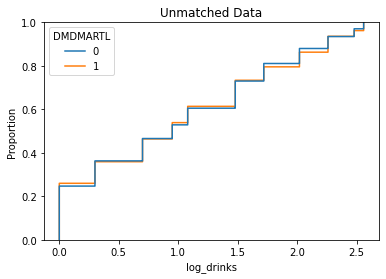

In [7]:
fig, ax = plt.subplots(figsize=(6,4))
# # sns.boxplot(x='RIAGENDR', y='log_drinks', hue='DMDMARTL', data=dr)
sns.ecdfplot(data=dr, x="log_drinks", hue="DMDMARTL", ax=ax)
ax.set_title("Unmatched Data")
plt.show()

## Matching with PyMatch

In [8]:
test = dr[dr.DMDMARTL == 1].copy()
control = dr[dr.DMDMARTL == 0].copy()

In [9]:
from pymatch.Matcher import Matcher
m = Matcher(test, control, yvar="DMDMARTL", exclude=[])

Formula:
DMDMARTL ~ RIAGENDR+RIDAGEYR+log_drinks
n majority: 2130
n minority: 534


In [10]:
%%bash
# must tweak source code: https://github.com/benmiroglio/pymatch/issues/23
sed -i 's/y == preds/y.to_numpy().T == preds/1' ~/venv/lib/python3.7/site-packages/pymatch/Matcher.py
grep "== preds" ~/venv/lib/python3.7/site-packages/pymatch/Matcher.py

        return (y.to_numpy().T == preds).sum() * 1.0 / len(y)


Fitting Models on Balanced Samples: 100\100
Average Accuracy: 59.42%
/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


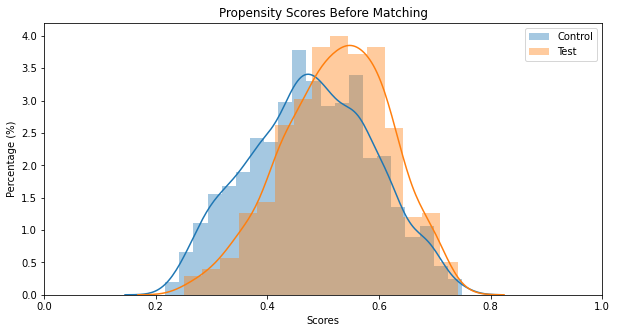

In [11]:
np.random.seed(20210301)
m.fit_scores(balance=True, nmodels=100)
m.predict_scores()
m.plot_scores()

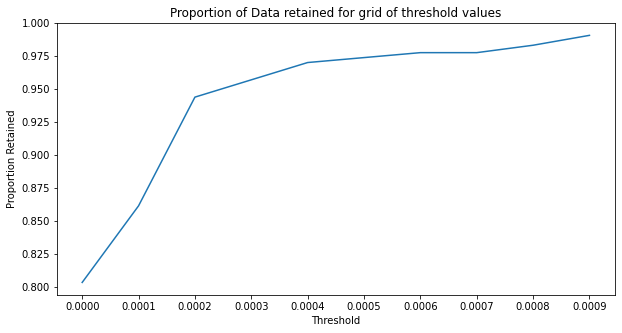

In [12]:
m.tune_threshold(method='random')

In [13]:
m.match(method="min", nmatches=1, threshold=0.0008)
m.record_frequency()

,freq,n_records
0,1,766
1,2,67
2,3,27
3,4,10
4,5,5
5,7,2
6,8,1


In [14]:
m.assign_weight_vector()
m.matched_data.sort_values("match_id").head(6)

,record_id,weight,RIAGENDR,RIDAGEYR,DMDMARTL,log_drinks,scores,match_id
0,0,1.000000,0,66.0,1,1.08,0.635431,0
850,1776,0.333333,0,62.0,0,2.02,0.634327,0
546,580,1.000000,1,67.0,0,1.48,0.514501,1
1,1,1.000000,1,67.0,1,1.48,0.514501,1
1007,2375,0.333333,0,60.0,0,1.08,0.597332,2
2,2,1.000000,0,60.0,1,1.08,0.597332,2


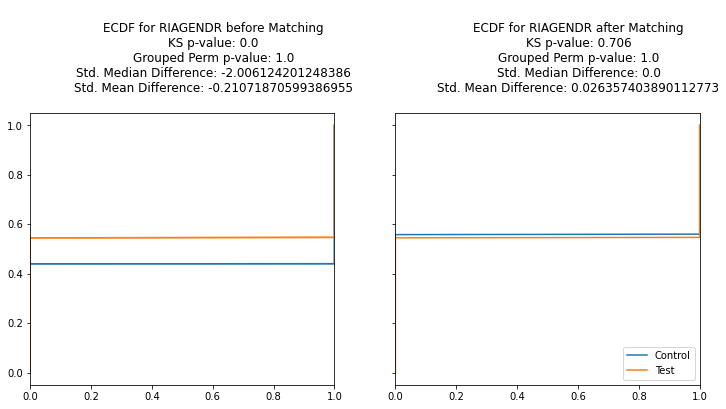

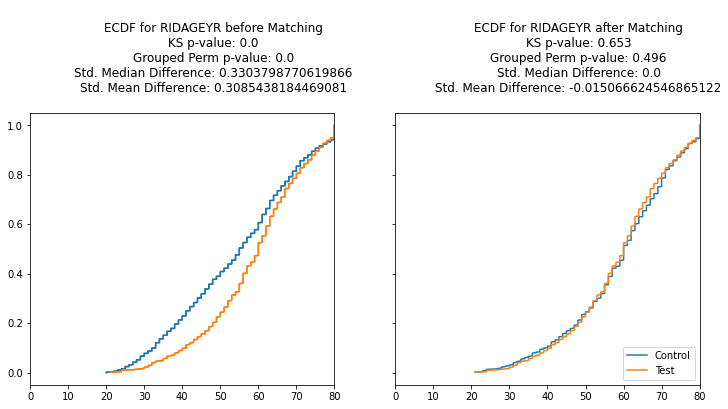

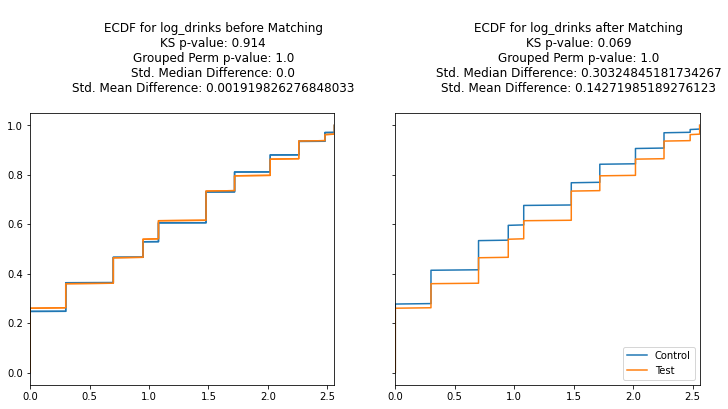

In [15]:
cc = m.compare_continuous(return_table=True)

In [16]:
# ALQ = pd.read_sas('https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/ALQ_J.XPT')
# DEMO = pd.read_sas('https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/DEMO_J.XPT')

# url = 'https://wwwn.cdc.gov/nchs/nhanes/Search/DataPage.aspx?Component=Laboratory&CycleBeginYear=2017'
# df = pd.read_html(url)[0]  # attrs={'id':'GridView1'}

# import requests
# r = requests.get(url)
# lines = r.content.decode('utf-8').split('\n')
# [l.split('"')[1] for l in lines if '.XPT' in l]

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=98f37550-cbaa-491c-a3ea-f393696dc041' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>